In [1]:
import random
from tqdm import tqdm

In [2]:
from scipy.stats import entropy
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:
import matplotlib.pyplot as plt

In [5]:
bs=20
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [6]:
# class CVAE(nn.Module):
#     def __init__(self, x_dim, h_dim, z_dim, y_dim):
#         super(CVAE, self).__init__()
        
#         # encoder part
#         self.fc1 = nn.Linear(x_dim + y_dim, h_dim)
#         self.fc21 = nn.Linear(h_dim, z_dim)
#         self.fc22 = nn.Linear(h_dim, z_dim)
#         # decoder part
#         self.fc3 = nn.Linear(z_dim + x_dim, h_dim)
#         self.fc4 = nn.Linear(h_dim, y_dim)
    
#     def encoder(self, x, y):
#         concat_input = torch.cat([x, y], 1)
#         h = F.relu(self.fc1(concat_input))
#         return self.fc21(h), self.fc22(h)
    
#     def sampling(self, mu, log_var):
#         std = torch.exp(0.5*log_var)
#         eps = torch.randn_like(std)
#         return eps.mul(std).add(mu) # return z sample
    
#     def decoder(self, z, x):
#         concat_input = torch.cat([z, x.view(-1, 784)], 1)
#         h = F.relu(self.fc3(concat_input))
#         return F.log_softmax(self.fc4(h))
    
#     def forward(self, x, y):
#         mu, log_var = self.encoder(x.view(-1, 784), y)
#         z = self.sampling(mu, log_var)
#         return self.decoder(z, x), mu, log_var

In [7]:
# # condition after convolution

# class CVAE(nn.Module):
#     def __init__(self, x_dim, h1_dim, h2_dim, z_dim, y_dim):
#         super(CVAE, self).__init__()
        
#         # encoder part
#         self.fc1 = nn.Linear(x_dim, h1_dim)
#         self.fc2 = nn.Linear(h1_dim + y_dim, h2_dim)
#         self.fc31 = nn.Linear(h2_dim, z_dim)
#         self.fc32 = nn.Linear(h2_dim, z_dim)
#         # decoder part
#         self.fc4 = nn.Linear(x_dim, h1_dim)
#         self.fc5 = nn.Linear(h1_dim + y_dim, h2_dim)
#         self.fc6 = nn.Linear(h2_dim, y_dim)
    
#     def encoder(self, x, y):
# #         concat_input = torch.cat([x, y], 1)
#         h1 = F.relu(self.fc1(x))
#         h2 = F.relu(self.fc2(torch.cat([h1, y], 1)))
#         return self.fc31(h2), self.fc32(h2)
    
#     def sampling(self, mu, log_var):
#         std = torch.exp(0.5*log_var)
#         eps = torch.randn_like(std)
#         return eps.mul(std).add(mu) # return z sample
    
#     def decoder(self, z, x):
#         h1 = F.relu(self.fc4(x.view(-1, 784)))
#         h2 = F.relu(self.fc5(torch.cat([h1, z], 1)))
#         return F.log_softmax(self.fc6(h2))
    
#     def forward(self, x, y):
#         mu, log_var = self.encoder(x.view(-1, 784), y)
#         z = self.sampling(mu, log_var)
#         return self.decoder(z, x), mu, log_var

In [8]:
# condition after convolution
# more hidden layers

class CVAE(nn.Module):
    def __init__(self, x_dim, hs_dim, z_dim, y_dim, tie_weights=False):
        super(CVAE, self).__init__()
        
        assert len(hs_dim) >= 2
        self.tie_weights = tie_weights
        
        # encoder part for x
        self.encode_x = []
        for i, h_dim in enumerate(hs_dim[:-1]):
            if i == 0:
                self.encode_x.append(nn.Linear(x_dim, h_dim))
            else:
                self.encode_x.append(nn.Linear(hs_dim[i-1], h_dim))
        # last layer of encoder combines x and y
        self.encode_xy = nn.Linear(hs_dim[-2] + y_dim, hs_dim[-1])
        # compute posterior distribution parameters
        self.posterior_mean = nn.Linear(hs_dim[-1], z_dim)
        self.posterior_logvar = nn.Linear(hs_dim[-1], z_dim)
        
        # prior network
        if not self.tie_weights:
            self.prior_x = []
            for i, h_dim in enumerate(hs_dim[:-1]):
                if i == 0:
                    self.prior_x.append(nn.Linear(x_dim, h_dim))
                else:
                    self.prior_x.append(nn.Linear(hs_dim[i-1], h_dim))
        else:
            self.prior_x = self.encode_x
        self.prior_mean = nn.Linear(hs_dim[-2], z_dim)
        self.prior_logvar = nn.Linear(hs_dim[-2], z_dim)
        
        if not self.tie_weights:
            # decoder part for x
            self.decode_x = []
            for i, h_dim in enumerate(hs_dim[:-1]):
                if i == 0:
                    self.decode_x.append(nn.Linear(x_dim, h_dim))
                else:
                    self.decode_x.append(nn.Linear(hs_dim[i-1], h_dim))
        else:
            self.decode_x = self.encode_x
        # last layer of decoder combines x and z
        self.decode_xz = nn.Linear(hs_dim[-2] + z_dim, hs_dim[-1])
        # compute y
        self.output = nn.Linear(hs_dim[-1], y_dim)
    
    def prior(self, x):
        for layer in self.prior_x:
            x = F.relu(layer(x))
        return self.prior_mean(x), self.prior_logvar(x)
    
    def encoder(self, x, y):
        for layer in self.encode_x:
            x = F.relu(layer(x))
        h = F.relu(self.encode_xy(torch.cat([x, y], 1)))
        return self.posterior_mean(h), self.posterior_logvar(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu) # return z sample
    
    def decoder(self, z, x):
        for layer in self.decode_x:
            x = F.relu(layer(x))
        h = F.relu(self.decode_xz(torch.cat([x, z], 1)))
        return F.log_softmax(self.output(h))
    
    def forward(self, x, y):
        x = x.view(-1, 784)
        mu_q, log_var_q = self.encoder(x, y)
        mu_p, log_var_p = self.prior(x)
        z = self.sampling(mu_q, log_var_q)
        return self.decoder(z, x), mu_q, log_var_q, mu_p, log_var_p
    
    def inference(self, x):
        # not efficient for multiple samples since the common part to encode x will be run multiple times!
        x = x.view(-1, 784)
        mu_p, log_var_p = self.prior(x)
        z = self.sampling(mu_p, log_var_p )
        return self.decoder(z, x), mu_p, log_var_p

In [9]:

# z_dim = 10
z_dim = 2

# cvae = CVAE(x_dim=784, h1_dim=50, h2_dim=10, z_dim=z_dim, y_dim=10)

# cvae = CVAE(x_dim=784, hs_dim=[20, 10, 10], z_dim=z_dim, y_dim=10)
# cvae = CVAE(x_dim=784, hs_dim=[20, 10, 5], z_dim=z_dim, y_dim=10)
# cvae = CVAE(x_dim=784, hs_dim=[50, 10, 5], z_dim=z_dim, y_dim=10)
# cvae = CVAE(x_dim=784, hs_dim=[50, 10, 10], z_dim=z_dim, y_dim=10)
# cvae = CVAE(x_dim=784, hs_dim=[50, 10], z_dim=z_dim, y_dim=10)
# cvae = CVAE(x_dim=784, hs_dim=[50, 10, 5, 10], z_dim=z_dim, y_dim=10)

cvae = CVAE(x_dim=784, hs_dim=[20, 10, 10], z_dim=z_dim, y_dim=10, tie_weights=True)

In [10]:
cvae

CVAE(
  (encode_xy): Linear(in_features=20, out_features=10, bias=True)
  (posterior_mean): Linear(in_features=10, out_features=2, bias=True)
  (posterior_logvar): Linear(in_features=10, out_features=2, bias=True)
  (prior_mean): Linear(in_features=10, out_features=2, bias=True)
  (prior_logvar): Linear(in_features=10, out_features=2, bias=True)
  (decode_xz): Linear(in_features=12, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=10, bias=True)
)

In [11]:
optimizer = optim.Adam(cvae.parameters())

In [12]:
log_softmax_loss = nn.NLLLoss(reduction='sum')  

# # return reconstruction error + KL divergence losses
# def loss_function(y_pred, y, mu, log_var):
#     sm_loss = log_softmax_loss(y_pred, y)
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return sm_loss, KLD

def loss_function(y_pred, y, mu_q, log_var_q, mu_p, log_var_p):
    sm_loss = log_softmax_loss(y_pred, y)
    KLD = 0.5 * torch.sum(log_var_q.exp()/log_var_p.exp() + \
                          (mu_p - mu_q).pow(2)/log_var_p.exp() - 1 + \
                          log_var_p - log_var_q)
    return sm_loss, KLD

# one-hot encoding
def one_hot(labels, class_size): 
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

In [13]:
def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = torch.cat([x_batch, x_batch], 0)
        
        # make toy data
        y_batch_p1 = y_batch + 1
        y_batch_p1[y_batch_p1==10] = 0
        y_batch = torch.cat([y_batch, y_batch_p1], 0)

        y_oh_batch = one_hot(y_batch, class_size=10)
        optimizer.zero_grad()
        
        y_pred, mu_q, log_var_q, mu_p, log_var_p = cvae(x_batch, y_oh_batch)
        sm_loss, KLD = loss_function(y_pred, y_batch, mu_q, log_var_q, mu_p, log_var_p)
        loss = sm_loss + KLD
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} = {:.6f} + {:.6f}'.format(
                epoch, batch_idx * len(x_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
            sm_loss.item(), KLD.item()))

In [14]:
def test():
    cvae.eval()
    test_loss= 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            y_oh_batch = one_hot(y_batch, class_size=10)
            y_pred, mu_q, log_var_q, mu_p, log_var_p = cvae(x_batch, y_oh_batch)
            # sum up batch loss
            sm_loss, KLD = loss_function(y_pred, y_batch, mu_q, log_var_q, mu_p, log_var_p)
            test_loss += (sm_loss.item() + KLD.item())
        
    test_loss /= (len(test_loader.dataset)/test_loader.batch_size)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [15]:
for epoch in range(4):  # TODO more epochs?
    train(epoch)
    test()

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 94.002426 = 92.867424 + 1.135002
Train Epoch: 0 [4000/60000 (3%)]	Loss: 91.394218 = 91.320541 + 0.073676
Train Epoch: 0 [8000/60000 (7%)]	Loss: 92.241623 = 92.183289 + 0.058338
Train Epoch: 0 [12000/60000 (10%)]	Loss: 92.224869 = 92.157936 + 0.066933
Train Epoch: 0 [16000/60000 (13%)]	Loss: 91.377235 = 91.308296 + 0.068942
Train Epoch: 0 [20000/60000 (17%)]	Loss: 93.038116 = 92.976807 + 0.061309
Train Epoch: 0 [24000/60000 (20%)]	Loss: 92.349525 = 92.255096 + 0.094428
Train Epoch: 0 [28000/60000 (23%)]	Loss: 91.850868 = 91.782982 + 0.067885
Train Epoch: 0 [32000/60000 (27%)]	Loss: 92.420036 = 92.321617 + 0.098419
Train Epoch: 0 [36000/60000 (30%)]	Loss: 91.731323 = 91.632942 + 0.098385
Train Epoch: 0 [40000/60000 (33%)]	Loss: 91.868729 = 91.773781 + 0.094947
Train Epoch: 0 [44000/60000 (37%)]	Loss: 91.580704 = 91.490250 + 0.090455
Train Epoch: 0 [48000/60000 (40%)]	Loss: 91.187706 = 91.098366 + 0.089339
Train Epoch: 0 [52000/60000 (43%)]	Loss: 91.802

Train Epoch: 3 [80000/60000 (67%)]	Loss: 82.504440 = 81.686958 + 0.817480
Train Epoch: 3 [84000/60000 (70%)]	Loss: 85.784752 = 84.953217 + 0.831534
Train Epoch: 3 [88000/60000 (73%)]	Loss: 83.300102 = 82.557289 + 0.742814
Train Epoch: 3 [92000/60000 (77%)]	Loss: 80.533394 = 79.711380 + 0.822011
Train Epoch: 3 [96000/60000 (80%)]	Loss: 87.246643 = 86.545555 + 0.701087
Train Epoch: 3 [100000/60000 (83%)]	Loss: 83.874985 = 82.922119 + 0.952869
Train Epoch: 3 [104000/60000 (87%)]	Loss: 84.142288 = 83.206787 + 0.935499
Train Epoch: 3 [108000/60000 (90%)]	Loss: 84.657822 = 83.505867 + 1.151955
Train Epoch: 3 [112000/60000 (93%)]	Loss: 84.446526 = 83.441254 + 1.005269
Train Epoch: 3 [116000/60000 (97%)]	Loss: 84.505043 = 83.498192 + 1.006850
====> Test set loss: 41.8416


In [16]:
# # random image

# num_row = 4
# num_col = 5
# num = num_row * num_col

# fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
# for i in range(num):
#     ax = axes[i//num_col, i%num_col]
#     idx = random.randint(a=0, b=10000)
#     tmp = test_dataset[idx][0]
#     ax.imshow(tmp.numpy()[0, :, :], cmap='gray', interpolation='none')
#     ax.set_title('i:{} l:{}'.format(idx, test_dataset[idx][1]))
# plt.tight_layout()
# plt.show()


In [17]:
# demonstrate prediction
# only running 'decoder', i.e. x, z -> y


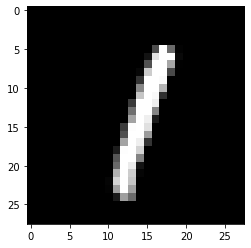

In [18]:
# x_debug, y_debug = train_dataset[500]



x_debug, y_debug = test_dataset[5]

# x_debug, y_debug = test_dataset[7]

# x_debug, y_debug = test_dataset[10]

# x_debug, y_debug = test_dataset[500]


# plot x
plt.imshow(x_debug.numpy()[0, :, :], cmap='gray', interpolation='none')

In [19]:
y_debug

1

In [20]:
yp_all = []
for _ in range(1000):
#     z_debug = cvae.sampling(torch.Tensor([[0] * z_dim]), torch.Tensor([[0] * z_dim]))  # from prior, z dim = 2
#     # print(z_debug)
#     yp_debug = cvae.decoder(x=x_debug.view(-1, 784), z=z_debug)
    # print(yp_debug.exp())
    yp_debug, mu_p, log_var_p = cvae.inference(x=x_debug.view(-1, 784))
    yp_all.append(yp_debug.argmax().item())

/Users/alicegao/anaconda2/envs/yeast_d_cell/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
for class_label in range(10):
    print("Class {}, count {}/{}".format(class_label, yp_all.count(class_label), len(yp_all)))

Class 0, count 0/1000
Class 1, count 0/1000
Class 2, count 836/1000
Class 3, count 160/1000
Class 4, count 4/1000
Class 5, count 0/1000
Class 6, count 0/1000
Class 7, count 0/1000
Class 8, count 0/1000
Class 9, count 0/1000


In [22]:
yp_debug.exp()

tensor([[0.0331, 0.1042, 0.2068, 0.1577, 0.1473, 0.0580, 0.0567, 0.1025, 0.0791,
         0.0547]], grad_fn=<ExpBackward>)

In [23]:
# check how many example predicts bimodal distribution
# training

n_sample = 100
n_datapoint = 1000

p_all = []

for _ in tqdm(range(n_datapoint)):
    idx = random.randint(a=0, b=len(train_dataset)-1)
    x_debug, y_debug = train_dataset[idx]

    yp_all = []
    for _ in range(n_sample):
#         z_debug = cvae.sampling(torch.Tensor([[0] * z_dim]), torch.Tensor([[0] * z_dim]))  # from prior, z dim = 2
#         # print(z_debug)
#         yp_debug = cvae.decoder(x=x_debug.view(-1, 784), z=z_debug)
        # print(yp_debug.exp())
        yp_debug, mu_p, log_var_p = cvae.inference(x=x_debug.view(-1, 784))
        yp_all.append(yp_debug.argmax().item())
    # calculation percent times the top hit class was predicted
    class_count = [yp_all.count(class_label) for class_label in range(10)]
    # entropy
    p_all.append(entropy(np.asarray(class_count)/n_sample))



100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s]


(array([ 98.,  94., 122., 231., 170., 143., 100.,  26.,  12.,   4.]),
 array([0.        , 0.1718072 , 0.3436144 , 0.51542159, 0.68722879,
        0.85903599, 1.03084319, 1.20265038, 1.37445758, 1.54626478,
        1.71807198]),
 <a list of 10 Patch objects>)

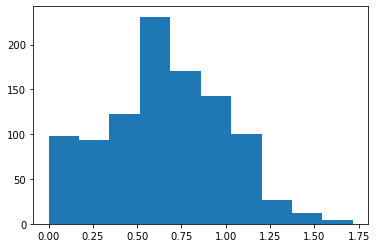

In [24]:
plt.hist(p_all)

In [25]:
# check how many example predicts bimodal distribution
# testing

n_sample = 100
n_datapoint = 1000

p_all = []

for _ in tqdm(range(n_datapoint)):
    idx = random.randint(a=0, b=len(test_dataset)-1)
    x_debug, y_debug = test_dataset[idx]

    yp_all = []
    for _ in range(n_sample):
#         z_debug = cvae.sampling(torch.Tensor([[0] * z_dim]), torch.Tensor([[0] * z_dim]))  # from prior, z dim = 2
#         # print(z_debug)
#         yp_debug = cvae.decoder(x=x_debug.view(-1, 784), z=z_debug)
        # print(yp_debug.exp())
        yp_debug, mu_p, log_var_p = cvae.inference(x=x_debug.view(-1, 784))
        yp_all.append(yp_debug.argmax().item())
    # calculation percent times the top hit class was predicted
    class_count = [yp_all.count(class_label) for class_label in range(10)]
    # entropy
    p_all.append(entropy(np.asarray(class_count)/n_sample))



100%|██████████| 1000/1000 [00:27<00:00, 36.37it/s]


(array([ 78.,  93., 130., 202., 185., 146., 114.,  39.,  10.,   3.]),
 array([0.        , 0.16682787, 0.33365575, 0.50048362, 0.6673115 ,
        0.83413937, 1.00096725, 1.16779512, 1.33462299, 1.50145087,
        1.66827874]),
 <a list of 10 Patch objects>)

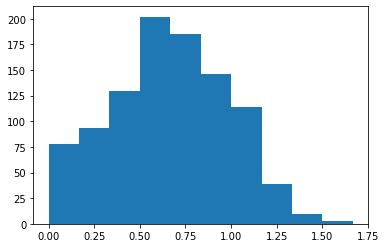

In [26]:
plt.hist(p_all)

In [27]:
entropy([0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0])  # this is what we want

0.6931471805599453

In [35]:
target = torch.randint(0, 10, (10,)).reshape([2, 5])
one_hot = torch.nn.functional.one_hot(target, num_classes=10)

In [36]:
target

tensor([[2, 8, 1, 9, 0],
        [4, 4, 4, 0, 7]])

In [37]:
one_hot

tensor([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]])

In [38]:
one_hot.shape

torch.Size([2, 5, 10])

In [39]:
one_hot.shape[1]

5